./jpgs/1301.jpg

这个文件主要是一步一步记录了如何使用 OpenCV 识别出电表内容
为了更加直观，咱用 Jupyter 逐步进行讲解

咱也记录了相对不好的方法，便于 93 能看到不同方法的区别

./jpgs/1031.jpg


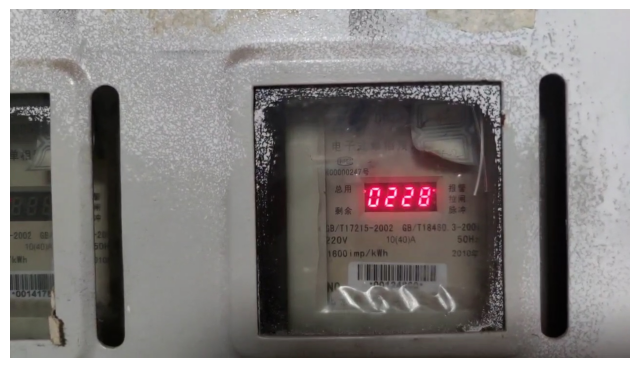

In [402]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random


'''

咱的命名规则：

em 开头是用来存和电表图片、图片信息相关的变量
emImg 是要识别的电表原图

后面再接单词缩写代表是经过了处理的图片
如 emImgGray 是黑白处理后的图, emImgGrayBlur 是黑白后又高斯模糊了的图


因为是方便理解的详细 Demo, 所以变量名可能会又臭又长, 但是相对便于理解


showImg 只是作为调试输出临时存放一下转成 RGB 的图

'''


# 读图
random.seed()
imgPath = "./jpgs/" + str (random.randint (1000, 1317)) + ".jpg"

print (imgPath)

# imgPath = "./jpgs/1140.jpg"

emImg = cv2.imread (imgPath)
if emImg is None:
    print ("图像读取失败")
    exit ()


# 预览转 RGB 格式的变量：showImg
showImg = cv2.cvtColor (emImg, cv2.COLOR_BGR2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

先对图片进行一些前期准备，让图片更易于处理

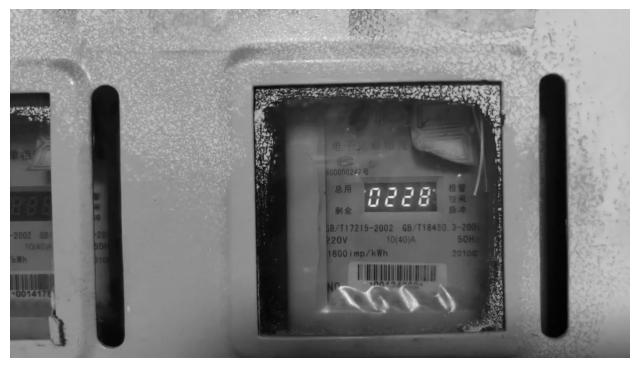

In [403]:
# 图像灰度化，去除颜色干扰
emImgGray = cv2.cvtColor (emImg, cv2.COLOR_BGR2GRAY)


showImg = cv2.cvtColor (emImgGray, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

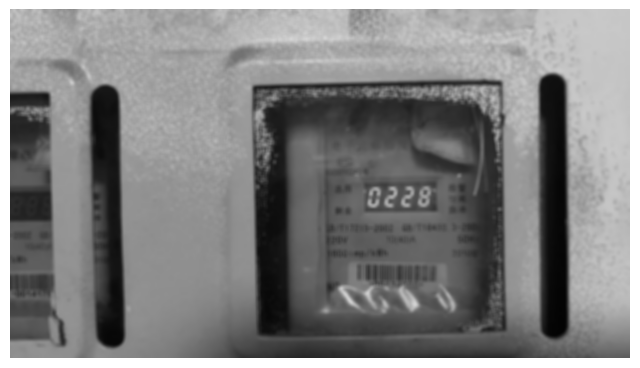

In [404]:
# 高斯模糊，减少噪音细节干扰
emImgGrayBlur = cv2.GaussianBlur (emImgGray, (9, 9), 5)


showImg = cv2.cvtColor (emImgGrayBlur, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()



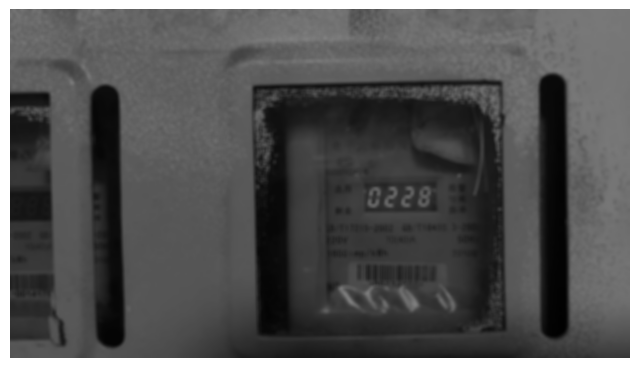

In [405]:
# 降低对比度
emImgGrayBlurExpr = np.clip(emImgGrayBlur * 0.6, 0, 255).astype(np.uint8)


showImg = cv2.cvtColor (emImgGrayBlurExpr, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

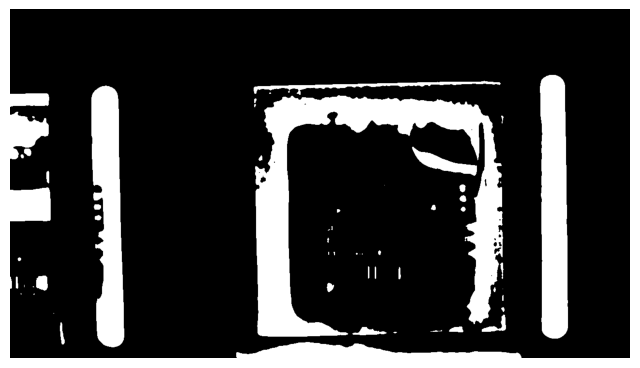

In [406]:
# 取图片在黑和白之间最中间的一个值：中值
imgMidVal = np.median (emImgGrayBlurExpr)

# 根据刚才的中值，将图片变为非黑即白的图片，比阈值亮就变纯白，比阈值黑就变纯黑，只有黑白就像 Bool 一样了（二值化）
emImgBoolVal, emImgBool = cv2.threshold (emImgGrayBlurExpr, imgMidVal - 45, 255, cv2.THRESH_BINARY)

# 将二值化的图片反色，因为电表相对墙壁更黑，反色后墙壁会变成黑色，电表变成白色
# 就像把墙壁 PS 成了透明的，便于后续的轮廓检测等处理
emImgBool = cv2.bitwise_not (emImgBool)

'''
kernel = np.ones((45, 45), np.uint8)
emImgBool = cv2.morphologyEx(emImgBool, cv2.MORPH_CLOSE, kernel)
'''


showImg = cv2.cvtColor (emImgBool, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

接下来就要来识别整个电表在图中的位置了

方法一：
直接描出轮廓，判断轮廓有几个顶点，如果有 4 个就是判断为矩形

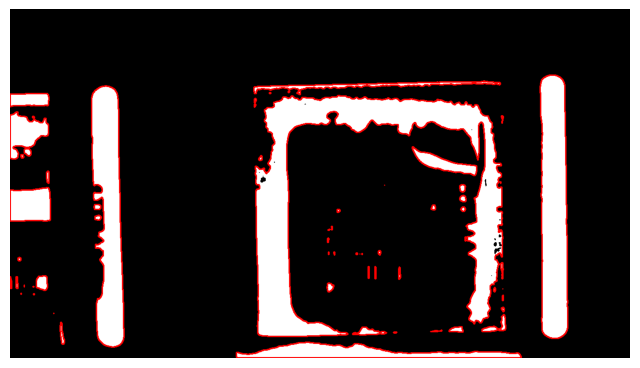

In [407]:
# 找出所有的轮廓
emCtrS, _ = cv2.findContours (emImgBool, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


showImg = cv2.cvtColor (emImgBool, cv2.COLOR_GRAY2RGB)
for emCtr in emCtrS:
    cv2.drawContours(showImg, [emCtr], -1, (255, 0, 0), 2)
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

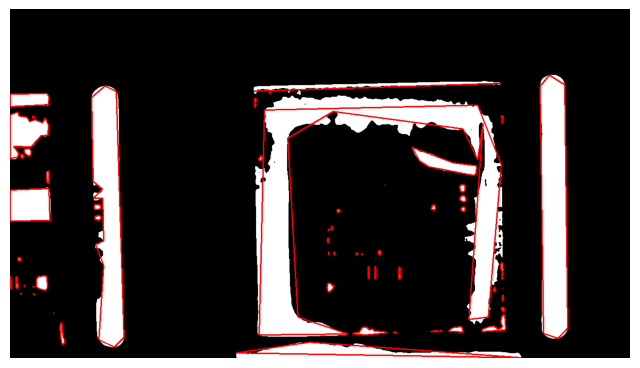

In [408]:
showImg = cv2.cvtColor (emImgBool, cv2.COLOR_GRAY2RGB)

# 将轮廓近似成多边形
for emCtr in emCtrS:
    epsilon = 0.01 * cv2.arcLength (emCtr, True)
    approx = cv2.approxPolyDP (emCtr, epsilon, True)
    cv2.drawContours(showImg, [approx], -1, (255, 0, 0), 2)


plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

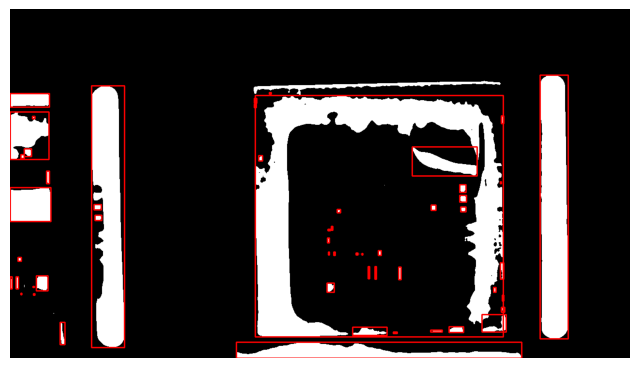

In [409]:
showImg = cv2.cvtColor (emImgBool, cv2.COLOR_GRAY2RGB)

# 找出大概有 4 个边的多边形
for emCtr in emCtrS:
    epsilon = 0.01 * cv2.arcLength (emCtr, True)
    approx = cv2.approxPolyDP (emCtr, epsilon, True)
    if len (approx) >= 3 and len (approx) <= 20:
        x, y, w, h = cv2.boundingRect (emCtr)
        cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 2)


plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

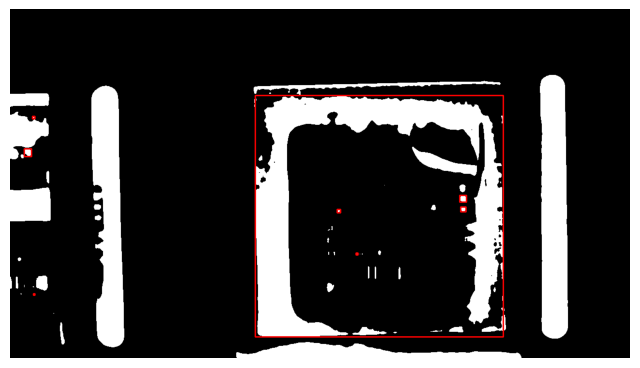

In [410]:
showImg = cv2.cvtColor (emImgBool, cv2.COLOR_GRAY2RGB)

# 进一步找出长宽比接近电表形状的
for emCtr in emCtrS:
    epsilon = 0.01 * cv2.arcLength (emCtr, True)
    approx = cv2.approxPolyDP (emCtr, epsilon, True)
    if len (approx) >= 3 and len (approx) <= 20:
        x, y, w, h = cv2.boundingRect (emCtr)
        if (h / w < 1.1) and (h / w > 0.9):
            cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

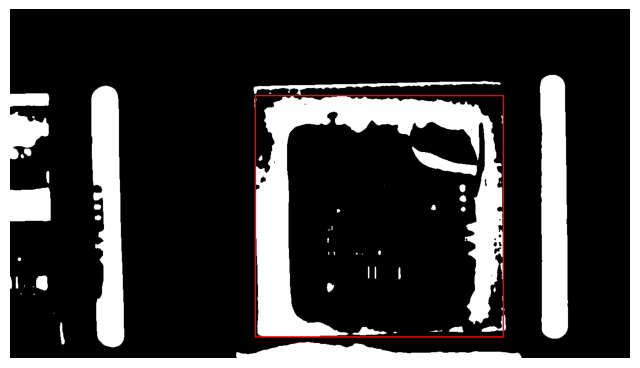

In [411]:
showImg = cv2.cvtColor (emImgBool, cv2.COLOR_GRAY2RGB)

# 再进一步筛出大小符合电表的
emHeight, emWidth, _ = emImg.shape
for emCtr in emCtrS:
    epsilon = 0.01 * cv2.arcLength (emCtr, True)
    approx = cv2.approxPolyDP (emCtr, epsilon, True)
    if len (approx) >= 3 and len (approx) <= 20:
        x, y, w, h = cv2.boundingRect (emCtr)
        if (h / w < 1.1) and (h / w > 0.9):
            if (emWidth * emHeight) / (w * h) < 6:
                cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 2)
                emBoxX, emBoxY, emBoxW, emBoxH = x, y, w, h

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

多边形曲线拟合矩形

In [412]:
# 多边形曲线拟合矩形

矩形梯形校正

In [413]:
# 多边形曲线拟合矩形

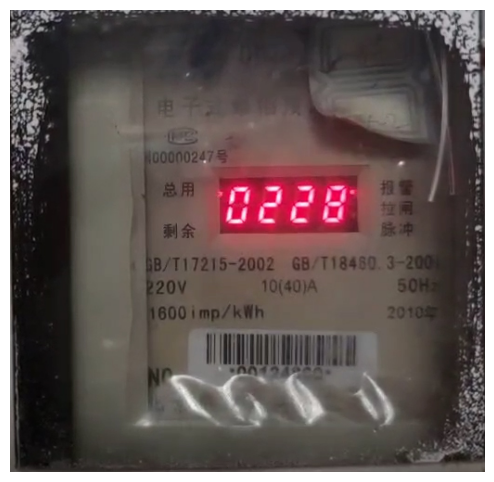

In [414]:
# 根据检测到的电表裁出原图
emImgBox = emImg [emBoxY:emBoxY + emBoxH, emBoxX:emBoxX + emBoxW]

showImg = cv2.cvtColor (emImgBox, cv2.COLOR_BGR2RGB)
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

得到电表的图后就已经屏蔽掉了一些无用信息

把流程再走一遍，分离出显示区域

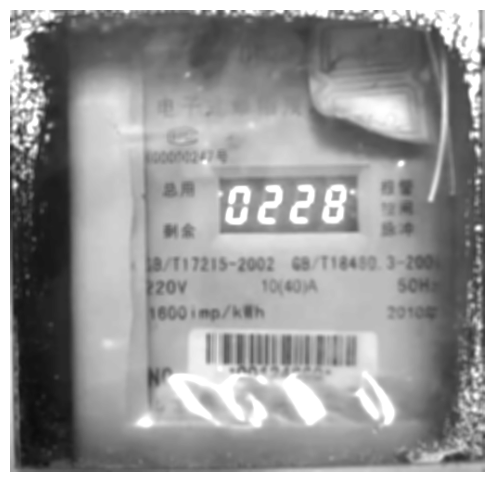

In [415]:
emImgBoxGray = cv2.cvtColor (emImgBox, cv2.COLOR_BGR2GRAY)
emImgBoxGrayBlur = cv2.GaussianBlur (emImgBoxGray, (5, 5), 3)
emImgBoxGrayBlurExpr = np.clip(emImgBoxGrayBlur * 1.9, 0, 255).astype(np.uint8)

showImg = cv2.cvtColor (emImgBoxGrayBlurExpr, cv2.COLOR_GRAY2RGB)
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

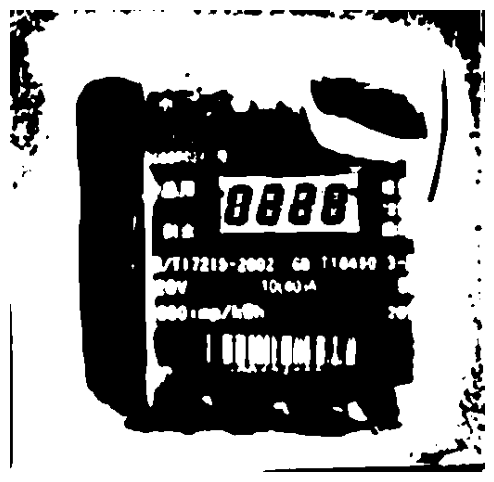

In [416]:
imgMidVal = np.median (emImgBoxGrayBlurExpr)

emImgBoxBoolVal, emImgBoxBool = cv2.threshold (emImgBoxGrayBlurExpr, imgMidVal + 5, 255, cv2.THRESH_BINARY)

emImgBoxBool = cv2.bitwise_not (emImgBoxBool)


showImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

In [417]:
'''
kernel = np.ones((10, 10), np.uint8)
emImgBoxBool = cv2.morphologyEx(emImgBoxBool, cv2.MORPH_CLOSE, kernel)


showImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()
'''

'\nkernel = np.ones((10, 10), np.uint8)\nemImgBoxBool = cv2.morphologyEx(emImgBoxBool, cv2.MORPH_CLOSE, kernel)\n\n\nshowImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB) \nplt.figure (figsize = (8, 6))\nplt.imshow (showImg)\nplt.axis ("off")\nplt.show ()\n'

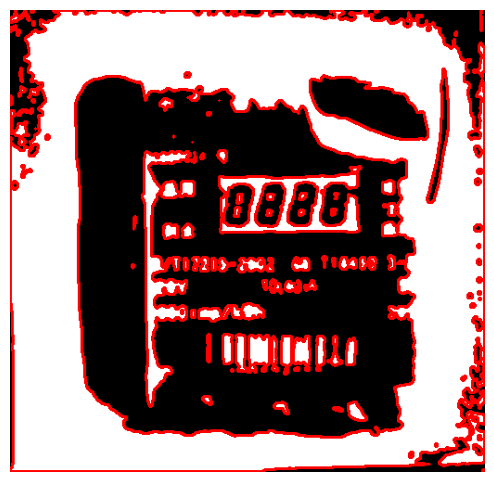

In [418]:
# 找出所有的轮廓

emBoxCtrS, hierarchy = cv2.findContours (emImgBoxBool, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

showImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB)
for emBoxCtr in emBoxCtrS:
    cv2.drawContours(showImg, [emBoxCtr], -1, (255, 0, 0), 2)

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

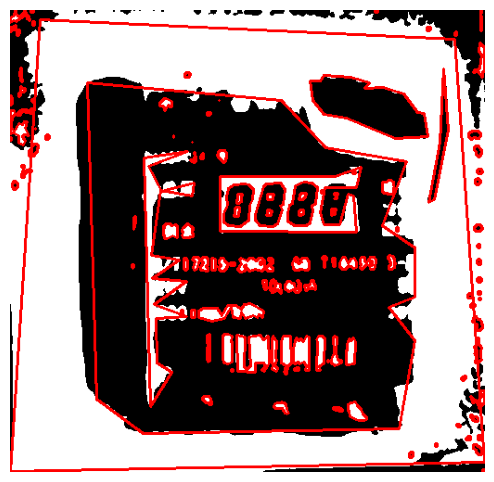

In [419]:
showImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB)

# 将轮廓近似成多边形
for emBoxCtr in emBoxCtrS:
    epsilon = 0.01 * cv2.arcLength (emBoxCtr, True)
    approxBox = cv2.approxPolyDP (emBoxCtr, epsilon, True)
    cv2.drawContours(showImg, [approxBox], -1, (255, 0, 0), 2)


plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

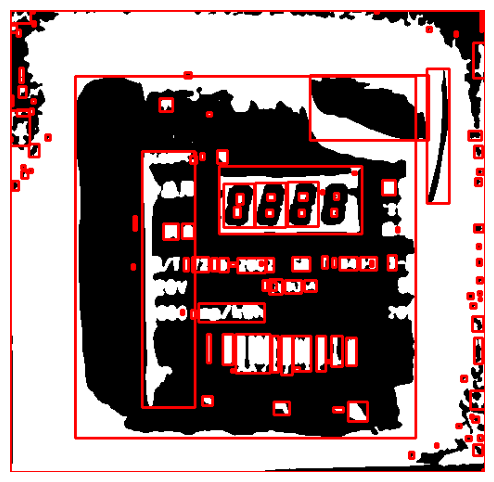

In [420]:
showImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB)

# 找出大概有 4 个边的多边形
for emBoxCtr in emBoxCtrS:
    epsilon = 0.01 * cv2.arcLength (emBoxCtr, True)
    approxBox = cv2.approxPolyDP (emBoxCtr, epsilon, True)
    if len (approxBox) >= 3 and len (approxBox) <= 25:
        x, y, w, h = cv2.boundingRect (emBoxCtr)
        cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 2)


plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

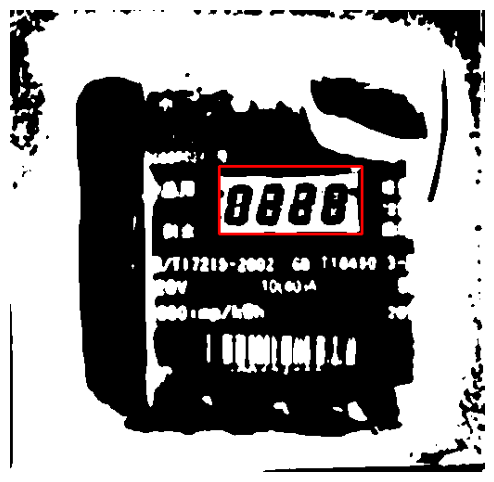

In [421]:
showImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB)

# 同样的方法筛出大小和形状符合电表的
emBoxHeight, emBoxWidth, _ = emImgBox.shape
for emBoxCtr in emBoxCtrS:
    epsilon = 0.01 * cv2.arcLength (emBoxCtr, True)
    approxBox = cv2.approxPolyDP (emBoxCtr, epsilon, True)
    if len (approxBox) >= 3 and len (approxBox) <= 25:
        x, y, w, h = cv2.boundingRect (emBoxCtr)
        if (w / h < 3.5) and (w / h > 2):
            if (emBoxWidth * emBoxHeight) / (w * h) < 50:
                cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 2)
                emDisX, emDisY, emDisW, emDisH = x, y, w, h

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

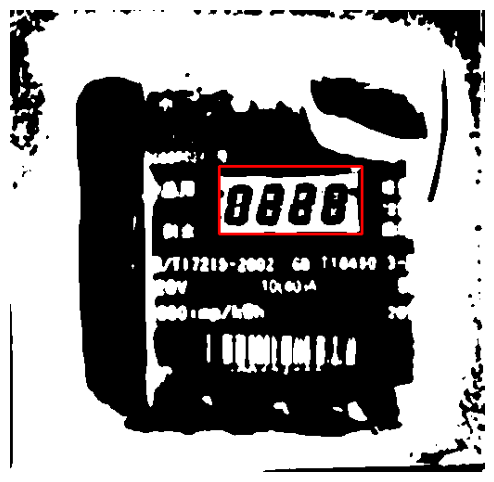

In [422]:
showImg = cv2.cvtColor (emImgBoxBool, cv2.COLOR_GRAY2RGB)

# 如果显示区域被割裂了就合并一下
emBoxHeight, emBoxWidth, _ = emImgBox.shape
emDisX = emDisY = emDisW = emDisH = 0
for emBoxCtr in emBoxCtrS:
    epsilon = 0.01 * cv2.arcLength (emBoxCtr, True)
    approxBox = cv2.approxPolyDP (emBoxCtr, epsilon, True)
    if len (approxBox) >= 3 and len (approxBox) <= 25:
        x, y, w, h = cv2.boundingRect (emBoxCtr)
        if (w / h < 3.5) and (w / h > 2):
            if (emBoxWidth * emBoxHeight) / (w * h) < 50:
                if (abs (emDisX - x) < 5) and (abs (emDisW - w)) < 5:
                    emDisX = min (emDisX, x)
                    emDisY = min (emDisY, y)
                    emDisW = max (emDisX + emDisW, x + w) - emDisX
                    emDisH = max (emDisY + emDisH, y + h) - emDisY
                else:
                    emDisX, emDisY, emDisW, emDisH = x, y, w, h
cv2.rectangle (showImg, (emDisX, emDisY), (emDisX + emDisW, emDisY + emDisH), (255, 0, 0), 2)

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

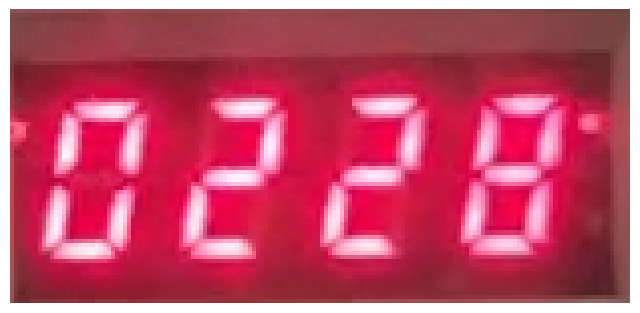

In [423]:
emImgDis = emImgBox [emDisY:emDisY + emDisH, emDisX:emDisX + emDisW]

showImg = cv2.cvtColor (emImgDis, cv2.COLOR_BGR2RGB)
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

In [424]:
'''
emImgDisHSV = cv2.cvtColor(emImgDis, cv2.COLOR_BGR2HSV)


emImgDisHSV [:, :, 1] = 255


emImgDis = cv2.cvtColor(emImgDisHSV, cv2.COLOR_HSV2BGR)

showImg = cv2.cvtColor (emImgDis, cv2.COLOR_BGR2RGB)
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()
'''

'\nemImgDisHSV = cv2.cvtColor(emImgDis, cv2.COLOR_BGR2HSV)\n\n\nemImgDisHSV [:, :, 1] = 255\n\n\nemImgDis = cv2.cvtColor(emImgDisHSV, cv2.COLOR_HSV2BGR)\n\nshowImg = cv2.cvtColor (emImgDis, cv2.COLOR_BGR2RGB)\nplt.figure (figsize = (8, 6))\nplt.imshow (showImg)\nplt.axis ("off")\nplt.show ()\n'

得到显示区域后，就可以对显示的内容进行识别了

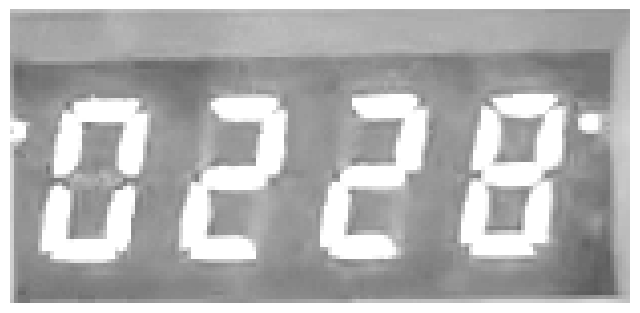

In [425]:
emImgDisGray = cv2.cvtColor (emImgDis, cv2.COLOR_BGR2GRAY)
emImgDisGrayExpr = np.clip(emImgDisGray * 1.9, 0, 255).astype(np.uint8)

showImg = cv2.cvtColor (emImgDisGrayExpr, cv2.COLOR_GRAY2RGB)
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

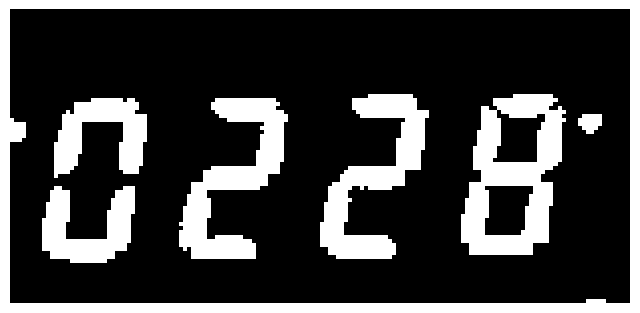

In [426]:
imgMidVal = np.median (emImgDisGrayExpr)

emImgDisBoolVal, emImgDisBool = cv2.threshold (emImgDisGrayExpr, imgMidVal + 55, 255, cv2.THRESH_BINARY)


showImg = cv2.cvtColor (emImgDisBool, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

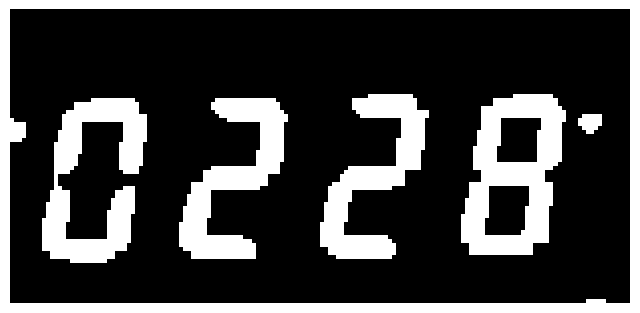

In [427]:
kernel = np.ones((3, 3), np.uint8)
emImgDisBool = cv2.morphologyEx(emImgDisBool, cv2.MORPH_CLOSE, kernel)


showImg = cv2.cvtColor (emImgDisBool, cv2.COLOR_GRAY2RGB) 
plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

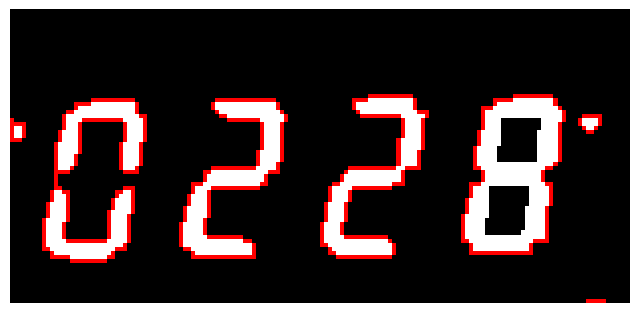

In [428]:
numCtrS, _ = cv2.findContours(emImgDisBool, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

showImg = cv2.cvtColor (emImgDisBool, cv2.COLOR_GRAY2RGB)
for numCtr in numCtrS:
    cv2.drawContours(showImg, [numCtr], -1, (255, 0, 0), 1)

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

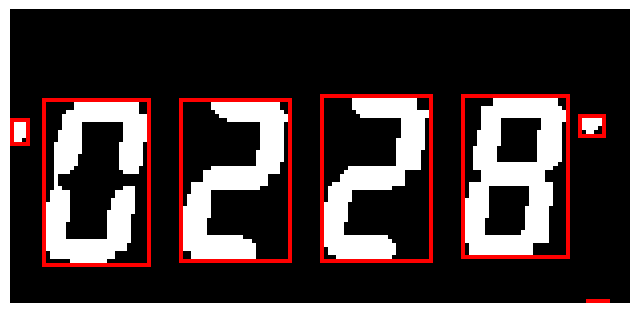

In [429]:
showImg = cv2.cvtColor (emImgDisBool, cv2.COLOR_GRAY2RGB)

numH, numW, _ = showImg.shape
numBoxS = []

# 得到轮廓的外接矩形
for numCtr in numCtrS:
    x, y, w, h = cv2.boundingRect (numCtr)
    numBoxS.append((x, y, w, h))
    cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 1)


plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

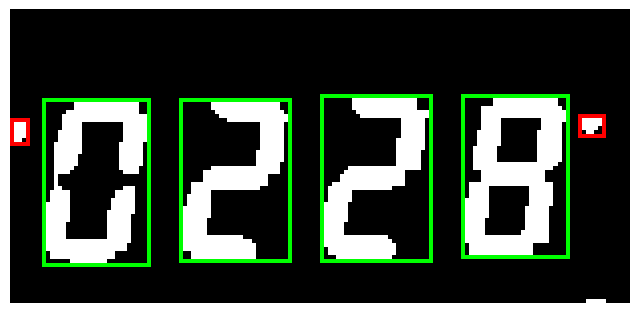

In [430]:
showImg = cv2.cvtColor (emImgDisBool, cv2.COLOR_GRAY2RGB)

# 区分所有的点（指示灯、小数点）和数字
dotS = []
numS = []
for x, y, w, h in numBoxS:
    if h >= 4 and h <= 13:
        if (w / h) >= 0.62 and (w / h) <= 1.34:
            dotS.append((x, y, w, h))
            cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 1)
        elif x < 3 or x > numW - 15:
            dotS.append((x, y, w, h))
            cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 1)
        else:
            numS.append((x, y, w, h))
            cv2.rectangle (showImg, (x, y), (x + w, y + h), (0, 255, 0), 1)
    else:
        if (x > 5) and (y > 5) and (x + w < numW - 5) and (y + h < numH - 5):
            numS.append((x, y, w, h))
            cv2.rectangle (showImg, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

先来处理指示灯

左上：1
左下：0
右上：1
右中：0
右下：0
小数点位置：-1


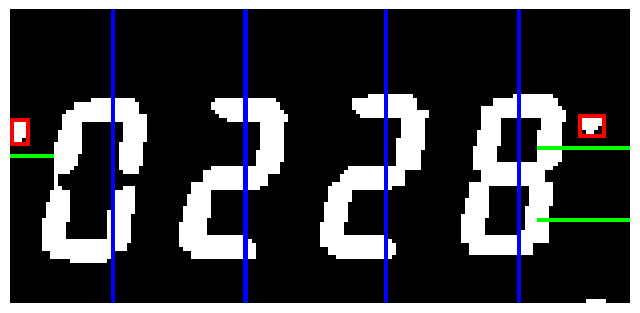

In [431]:
showImg = cv2.cvtColor (emImgDisBool, cv2.COLOR_GRAY2RGB)


litLeftUp = 0
litLeftDown = 0

litRightUp = 0
litRightMid = 0
litRightDown = 0

numDot = -1

for x, y, w, h in dotS:
    cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 0, 0), 1)
    if x < 10: # 左边指示灯
        if y + h / 2 <= numH / 2:
            litLeftUp = 1
        if y + h / 2 > numH / 2:
            litLeftDown = 1
    elif x > numW - 23: # 右边指示灯
        if y + h / 2 <= numH / 3 + 10:
            litRightUp = 1
        if (y + h / 2 > numH / 3 + 10) and (y + h / 2 <= numH / 3 * 2 + 10):
            litRightMid = 1
        if y + h / 2 > numH / 3 * 2 + 10:
            litRightDown = 1
    else: # 小数点
        if y  + h / 2 > numH / 2 + 10:
            if x >= (numW / 5 * 1 - 5) and x < (numW / 5 * 2 - 3):
                numDot = 1
            elif x >= (numW / 5 * 2 - 3) and x < (numW / 5 * 3 + 1):
                numDot = 2
            elif x >= (numW / 5 * 3 + 1) and x < (numW / 5 * 4 + 3):
                numDot = 3



print ("左上：" + str (litLeftUp))
print ("左下：" + str (litLeftDown))

print ("右上：" + str (litRightUp))
print ("右中：" + str (litRightMid))
print ("右下：" + str (litRightDown))

print ("小数点位置：" + str (numDot))


cv2.line(showImg, (0, int (numH / 2)), (10, int (numH / 2)), (0, 255, 0), 1)

cv2.line(showImg, (numW - 23, int (numH / 3 + 10)), (numW, int (numH / 3 + 10)), (0, 255, 0), 1)
cv2.line(showImg, (numW - 23, int (numH / 3 * 2 + 10) - 6), (numW, int (numH / 3 * 2 + 10) - 6), (0, 255, 0), 1)

cv2.line(showImg, (int (numW / 5 * 1) - 5, 0), (int (numW / 5 * 1) - 5, numH), (0, 0, 255), 1)
cv2.line(showImg, (int (numW / 5 * 2) - 3, 0), (int (numW / 5 * 2) - 3, numH), (0, 0, 255), 1)
cv2.line(showImg, (int (numW / 5 * 3) + 1, 0), (int (numW / 5 * 3) + 1, numH), (0, 0, 255), 1)
cv2.line(showImg, (int (numW / 5 * 4) + 3, 0), (int (numW / 5 * 4) + 3, numH), (0, 0, 255), 1)

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

再来处理数字

112 21 26 40


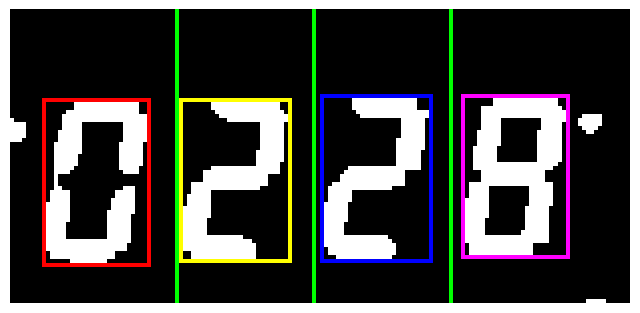

In [436]:
showImg = cv2.cvtColor (emImgDisBool, cv2.COLOR_GRAY2RGB)


num1 = num2 = num3 = num4 = -1
#         [ x,  y,  w,  h,  r,  b] （增加了 Right 和 Bottom 来辅助计算
numCtr1 = [-1, -1, -1, -1, -1, -1]
numCtr2 = [-1, -1, -1, -1, -1, -1]
numCtr3 = [-1, -1, -1, -1, -1, -1]
numCtr4 = [-1, -1, -1, -1, -1, -1]

for x, y, w, h in numS:
    if x <= numW / 4 * 1 + 3:
        if numCtr1 [0] == -1:
            numCtr1 = [x, y, w, h, x + w, y + h]
        else:
            numCtr1 [0] = min (numCtr1 [0], x)
            numCtr1 [1] = min (numCtr1 [1], y)
            numCtr1 [4] = max (numCtr1 [4], x + w)
            numCtr1 [5] = max (numCtr1 [5], y + h)
            numCtr1 [2] = numCtr1 [4] - numCtr1 [0]
            numCtr1 [3] = numCtr1 [5] - numCtr1 [1]
        num1 = 0
        cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 150, 100), 1)
    elif (x > numW / 4 * 1 + 3) and (x <= numW / 4 * 2 - 2):
        if numCtr2 [0] == -1:
            numCtr2 = [x, y, w, h, x + w, y + h]
        else:
            numCtr2 [0] = min (numCtr2 [0], x)
            numCtr2 [1] = min (numCtr2 [1], y)
            numCtr2 [4] = max (numCtr2 [4], x + w)
            numCtr2 [5] = max (numCtr2 [5], y + h)
            numCtr2 [2] = numCtr2 [4] - numCtr2 [0]
            numCtr2 [3] = numCtr2 [5] - numCtr2 [1]
        num2 = 0
        cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 255, 150), 1)
    elif (x > numW / 4 * 2 - 2) and (x <= numW / 4 * 3 - 6):
        if numCtr3 [0] == -1:
            numCtr3 = [x, y, w, h, x + w, y + h]
        else:
            numCtr3 [0] = min (numCtr3 [0], x)
            numCtr3 [1] = min (numCtr3 [1], y)
            numCtr3 [4] = max (numCtr3 [4], x + w)
            numCtr3 [5] = max (numCtr3 [5], y + h)
            numCtr3 [2] = numCtr3 [4] - numCtr3 [0]
            numCtr3 [3] = numCtr3 [5] - numCtr3 [1]
        num3 = 0
        cv2.rectangle (showImg, (x, y), (x + w, y + h), (150, 150, 255), 1)
    elif x > numW / 4 * 3 - 6:
        print (x, y, w, h)
        if numCtr4 [0] == -1:
            numCtr4 = [x, y, w, h, x + w, y + h]
        else:
            numCtr4 [0] = min (numCtr4 [0], x)
            numCtr4 [1] = min (numCtr4 [1], y)
            numCtr4 [4] = max (numCtr4 [4], x + w)
            numCtr4 [5] = max (numCtr4 [5], y + h)
            numCtr4 [2] = numCtr4 [4] - numCtr4 [0]
            numCtr4 [3] = numCtr4 [5] - numCtr4 [1]
        num4 = 0
        cv2.rectangle (showImg, (x, y), (x + w, y + h), (255, 150, 255), 1)


cv2.rectangle (showImg, (numCtr1[0], numCtr1[1]), (numCtr1[0] + numCtr1[2], numCtr1[1] + numCtr1[3]), (255, 0, 0), 1)
cv2.rectangle (showImg, (numCtr2[0], numCtr2[1]), (numCtr2[0] + numCtr2[2], numCtr2[1] + numCtr2[3]), (255, 255, 0), 1)
cv2.rectangle (showImg, (numCtr3[0], numCtr3[1]), (numCtr3[0] + numCtr3[2], numCtr3[1] + numCtr3[3]), (0, 0, 255), 1)
cv2.rectangle (showImg, (numCtr4[0], numCtr4[1]), (numCtr4[0] + numCtr4[2], numCtr4[1] + numCtr4[3]), (255, 0, 255), 1)


cv2.line(showImg, (int (numW / 4 * 1) + 3, 0), (int (numW / 4 * 1) + 3, numH), (0, 255, 0), 1)
cv2.line(showImg, (int (numW / 4 * 2 - 2), 0), (int (numW / 4 * 2 - 2), numH), (0, 255, 0), 1)
cv2.line(showImg, (int (numW / 4 * 3) - 6, 0), (int (numW / 4 * 3) - 6, numH), (0, 255, 0), 1)

plt.figure (figsize = (8, 6))
plt.imshow (showImg)
plt.axis ("off")
plt.show ()

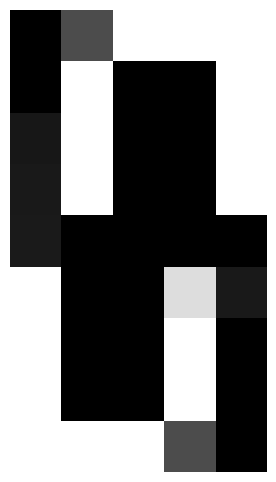

[1, 1, 1, 1, 1, 1, 0]


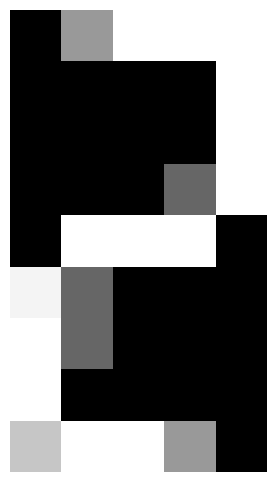

[1, 1, 0, 1, 1, 0, 1]


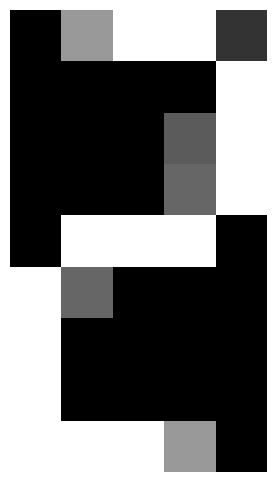

[1, 1, 0, 1, 1, 0, 1]


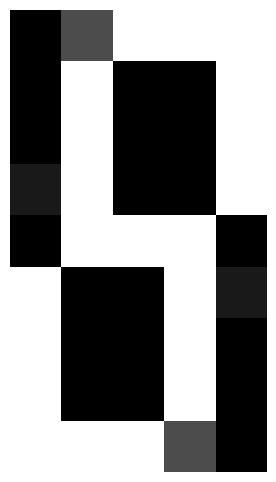

[1, 1, 1, 1, 1, 1, 1]
228


In [437]:
numBool1 = [0, 0, 0, 0, 0, 0, 0]
numBool2 = [0, 0, 0, 0, 0, 0, 0]
numBool3 = [0, 0, 0, 0, 0, 0, 0]
numBool4 = [0, 0, 0, 0, 0, 0, 0]

num = 0

num *= 10
if num1 != -1:
    num1Img = emImgDisBool [numCtr1 [1]:numCtr1 [5], numCtr1 [0]:numCtr1 [4]]
    num1Img = cv2.resize(num1Img, (5, 9))
    showImg = cv2.cvtColor (num1Img, cv2.COLOR_GRAY2RGB)

    plt.figure (figsize = (8, 6))
    plt.imshow (showImg)
    plt.axis ("off")
    plt.show ()


    if num1Img [0:1, 2:3].mean () > 30:
        numBool1 [0] = 1

    if num1Img [1:4, 4:5].mean () > 30:
        numBool1 [1] = 1

    if num1Img [5:8, 3:4].mean () > 30:
        numBool1 [2] = 1

    if num1Img [8:9, 1:3].mean () > 30:
        numBool1 [3] = 1

    if num1Img [5:8, 0:1].mean () > 30:
        numBool1 [4] = 1

    if num1Img [1:4, 1:2].mean () > 30:
        numBool1 [5] = 1

    if num1Img [4:5, 1:4].mean () > 30:
        numBool1 [6] = 1

    print (numBool1)

    if (numBool1 == [1, 1, 1, 1, 1, 1, 0]):
        num += 0
    elif (numBool1 == [0, 1, 1, 0, 0, 0, 0]):
        num += 1
    elif (numBool1 == [1, 1, 0, 1, 1, 0, 1]):
        num += 2
    elif (numBool1 == [1, 1, 1, 1, 0, 0, 1]):
        num += 3
    elif (numBool1 == [0, 1, 1, 0, 0, 1, 1]):
        num += 4
    elif (numBool1 == [1, 0, 1, 1, 0, 1, 1]):
        num += 5
    elif (numBool1 == [1, 0, 1, 1, 1, 1, 1]):
        num += 6
    elif (numBool1 == [1, 1, 1, 0, 0, 0, 0]):
        num += 7
    elif (numBool1 == [1, 1, 1, 1, 1, 1, 1]):
        num += 8
    elif (numBool1 == [1, 1, 1, 1, 0, 1, 1]):
        num += 9


num *= 10
if num2 != -1:
    num2Img = emImgDisBool [numCtr2 [1]:numCtr2 [5], numCtr2 [0]:numCtr2 [4]]
    num2Img = cv2.resize(num2Img, (5, 9))


    showImg = cv2.cvtColor (num2Img, cv2.COLOR_GRAY2RGB)
    plt.figure (figsize = (8, 6))
    plt.imshow (showImg)
    plt.axis ("off")
    plt.show ()


    if num2Img [0:1, 2:3].mean () > 30:
        numBool2 [0] = 1

    if num2Img [1:4, 4:5].mean () > 30:
        numBool2 [1] = 1

    if num2Img [5:8, 3:4].mean () > 30:
        numBool2 [2] = 1

    if num2Img [8:9, 1:3].mean () > 30:
        numBool2 [3] = 1

    if num2Img [5:8, 0:1].mean () > 30:
        numBool2 [4] = 1

    if num2Img [1:4, 1:2].mean () > 30:
        numBool2 [5] = 1

    if num2Img [4:5, 1:4].mean () > 30:
        numBool2 [6] = 1

    print (numBool2)

    if (numBool2 == [1, 1, 1, 1, 1, 1, 0]):
        num += 0
    elif (numBool2 == [0, 1, 1, 0, 0, 0, 0]):
        num += 1
    elif (numBool2 == [1, 1, 0, 1, 1, 0, 1]):
        num += 2
    elif (numBool2 == [1, 1, 1, 1, 0, 0, 1]):
        num += 3
    elif (numBool2 == [0, 1, 1, 0, 0, 1, 1]):
        num += 4
    elif (numBool2 == [1, 0, 1, 1, 0, 1, 1]):
        num += 5
    elif (numBool2 == [1, 0, 1, 1, 1, 1, 1]):
        num += 6
    elif (numBool2 == [1, 1, 1, 0, 0, 0, 0]):
        num += 7
    elif (numBool2 == [1, 1, 1, 1, 1, 1, 1]):
        num += 8
    elif (numBool2 == [1, 1, 1, 1, 0, 1, 1]):
        num += 9


num *= 10
if num3 != -1:
    num3Img = emImgDisBool [numCtr3 [1]:numCtr3 [5], numCtr3 [0]:numCtr3 [4]]
    num3Img = cv2.resize(num3Img, (5, 9))


    showImg = cv2.cvtColor (num3Img, cv2.COLOR_GRAY2RGB)
    plt.figure (figsize = (8, 6))
    plt.imshow (showImg)
    plt.axis ("off")
    plt.show ()


    if num3Img [0:1, 2:3].mean () > 30:
        numBool3 [0] = 1

    if num3Img [1:4, 4:5].mean () > 30:
        numBool3 [1] = 1

    if num3Img [5:8, 3:4].mean () > 30:
        numBool3 [2] = 1

    if num3Img [8:9, 1:3].mean () > 30:
        numBool3 [3] = 1

    if num3Img [5:8, 0:1].mean () > 30:
        numBool3 [4] = 1

    if num3Img [1:4, 1:2].mean () > 30:
        numBool3 [5] = 1

    if num3Img [4:5, 1:4].mean () > 30:
        numBool3 [6] = 1

    print (numBool3)

    if (numBool3 == [1, 1, 1, 1, 1, 1, 0]):
        num += 0
    elif (numBool3 == [0, 1, 1, 0, 0, 0, 0]):
        num += 1
    elif (numBool3 == [1, 1, 0, 1, 1, 0, 1]):
        num += 2
    elif (numBool3 == [1, 1, 1, 1, 0, 0, 1]):
        num += 3
    elif (numBool3 == [0, 1, 1, 0, 0, 1, 1]):
        num += 4
    elif (numBool3 == [1, 0, 1, 1, 0, 1, 1]):
        num += 5
    elif (numBool3 == [1, 0, 1, 1, 1, 1, 1]):
        num += 6
    elif (numBool3 == [1, 1, 1, 0, 0, 0, 0]):
        num += 7
    elif (numBool3 == [1, 1, 1, 1, 1, 1, 1]):
        num += 8
    elif (numBool3 == [1, 1, 1, 1, 0, 1, 1]):
        num += 9


num *= 10
if num4 != -1:
    num4Img = emImgDisBool [numCtr4 [1]:numCtr4 [5], numCtr4 [0]:numCtr4 [4]]
    num4Img = cv2.resize(num4Img, (5, 9))


    showImg = cv2.cvtColor (num4Img, cv2.COLOR_GRAY2RGB)
    plt.figure (figsize = (8, 6))
    plt.imshow (showImg)
    plt.axis ("off")
    plt.show ()


    if num4Img [0:1, 2:3].mean () > 30:
        numBool4 [0] = 1

    if num4Img [1:4, 4:5].mean () > 30:
        numBool4 [1] = 1

    if num4Img [5:8, 3:4].mean () > 30:
        numBool4 [2] = 1

    if num4Img [8:9, 1:3].mean () > 30:
        numBool4 [3] = 1

    if num4Img [5:8, 0:1].mean () > 30:
        numBool4 [4] = 1

    if num4Img [1:4, 1:2].mean () > 30:
        numBool4 [5] = 1

    if num4Img [4:5, 1:4].mean () > 30:
        numBool4 [6] = 1

    print (numBool4)

    if (numBool4 == [1, 1, 1, 1, 1, 1, 0]):
        num += 0
    elif (numBool4 == [0, 1, 1, 0, 0, 0, 0]):
        num += 1
    elif (numBool4 == [1, 1, 0, 1, 1, 0, 1]):
        num += 2
    elif (numBool4 == [1, 1, 1, 1, 0, 0, 1]):
        num += 3
    elif (numBool4 == [0, 1, 1, 0, 0, 1, 1]):
        num += 4
    elif (numBool4 == [1, 0, 1, 1, 0, 1, 1]):
        num += 5
    elif (numBool4 == [1, 0, 1, 1, 1, 1, 1]):
        num += 6
    elif (numBool4 == [1, 1, 1, 0, 0, 0, 0]):
        num += 7
    elif (numBool4 == [1, 1, 1, 1, 1, 1, 1]):
        num += 8
    elif (numBool4 == [1, 1, 1, 1, 0, 1, 1]):
        num += 9

print (num) 